In [99]:
import json
import pandas as pd
import plotly.express as px
import numpy as np
from wordcloud import *
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [100]:
with open('../data/docs.json', encoding = "utf8") as f:
    docs = json.load(f)

# Mots par document (sans ponctuation, sans stop-words)

In [101]:
nbDocs = len(docs)
tailleDocs = [len(doc) for doc in docs]
nbMots = sum(tailleDocs)

print(f"Nombre de documents : {nbDocs} | Nombre de mots : {nbMots}")

Nombre de documents : 9501 | Nombre de mots : 71333


In [102]:
for doc in docs:
    doc = [mot for mot in doc if mot not in ['~%', 'cl', 'kt']]

In [103]:
tailleDocs = pd.DataFrame(tailleDocs, columns = ["Lemme"])

fig = px.histogram(tailleDocs, x = "Lemme", title = "Histogramme du nombre de mots par documents")
fig.show()

# Importance des lemmes

## Présence globale (fréquence d'apparition sur le corpus)

In [104]:
freqMots = {}
ensembleMots = set()
for doc in docs:
    for mot in doc:
        if mot not in freqMots:
            ensembleMots.add(mot)
            freqMots[mot] = 1
        else:
            freqMots[mot] += 1

Enregistrement des lemmes (uniques) dans un fichier texte

In [105]:
file = open("../data/liste_lemmes.txt", 'w')
for lemme in freqMots.keys():
    file.writelines(lemme + '\n')
file.close()

Ordonnancement décroissant, transformation en _dataframe_

In [106]:
freqMots = sorted(freqMots.items(), key = lambda m: m[1], reverse = True)
freqMots = pd.DataFrame(freqMots, columns = ['Lemme', 'Occurrences'])
freqMots['Fréquence'] = freqMots['Occurrences'] * 100 / nbMots

### Lemmes les plus utilisés (représentatifs du sujet)

In [107]:
nbLemmesAfficher = 10
fig = px.bar(freqMots.iloc[:nbLemmesAfficher,:], x = 'Lemme', y = 'Fréquence',
title = "Fréquence (%) d'apparition des lemmes dans les propositions")
fig.show()

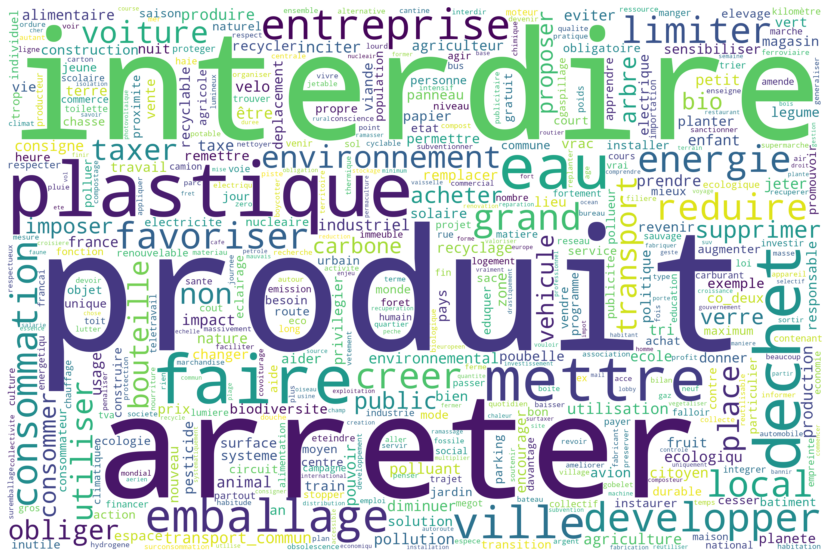

In [108]:
#Word Cloud
dict_wordcloud = freqMots.copy()
dict_wordcloud = dict_wordcloud.set_index("Lemme")
wordcloud = WordCloud(background_color="white", width=3000, height=2000, max_words=500)
wordcloud.generate_from_frequencies(frequencies=dict_wordcloud.to_dict()["Fréquence"])
plt.figure(figsize=[15,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Lemmes les moins utilisés (les plus discriminants)

In [109]:
freqMin = 100 / nbMots
motsUniques = [freqMots.loc[i,"Lemme"] for i in range(len(freqMots)) if freqMots.loc[i,"Fréquence"] == freqMin]
del freqMin

In [110]:
print(f"Nombre ; Proportion de mots n'ayant été utilisés qu'une seule fois sur l'ensemble des documents : {len(motsUniques)} ; {100 * len(motsUniques) / len(freqMots)} %.")

Nombre ; Proportion de mots n'ayant été utilisés qu'une seule fois sur l'ensemble des documents : 3266 ; 45.16664361775688 %.


## Termes discriminants (IDF, nombre de documents possédant chaque mot)

In [111]:
idf = {}
df = {}
for mot in ensembleMots:
    nbDocsMotPresent = 0
    for doc in docs:
        if mot in doc:
            nbDocsMotPresent += 1
    df[mot] = nbDocsMotPresent
    idf[mot] = - np.log(df[mot] / len(docs))

Ordonnancement décroissant, transformation en _dataframe_

In [112]:
idf = sorted(idf.items(), key = lambda m: m[1], reverse = True)
idf = pd.DataFrame(idf, columns = ['Lemme', 'IDF'])
df = sorted(df.items(), key = lambda m: m[1], reverse = True)
df = pd.DataFrame(df, columns = ['Lemme', 'DF (absolu)'])
df['DF'] = df['DF (absolu)'] / len(docs)
df["Nombre moyen par document"] = 0
for v in df.Lemme:
    df.loc[df['Lemme'] == v, "Nombre moyen par document"] = freqMots.loc[freqMots['Lemme'] == v, "Occurrences"].values / (df.loc[df['Lemme'] == v,'DF'].values * len(docs))

In [113]:
#nbLemmesAfficher = 20
fig = px.bar(idf.loc[:,:], x = 'Lemme', y = 'IDF',
title = "IDF des différents lemmes")
fig.show()

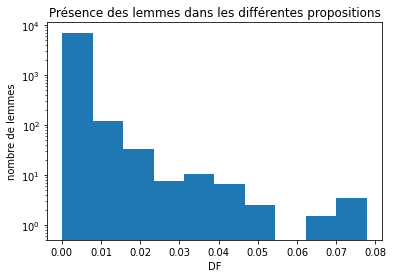

In [114]:
plt.hist(df.DF, log = True, bottom = .5)
plt.xlabel("DF")
plt.ylabel("nombre de lemmes")
_ = plt.title("Présence des lemmes dans les différentes propositions")

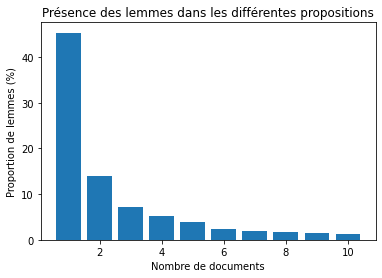

In [115]:
nbDocsLemmes = list(df.DF * len(docs))
nbDocsLemmes = np.array([int(v) for v in nbDocsLemmes])
valeurs = list(set(nbDocsLemmes))
valeurs = [v for v in valeurs if v <= 10]
valeurs.sort()
quantite = [100 * np.sum(nbDocsLemmes == v) / len(df.Lemme) for v in valeurs]
plt.bar(valeurs, quantite)
plt.title("Présence des lemmes dans les différentes propositions")
plt.xlabel("Nombre de documents")
_ = plt.ylabel("Proportion de lemmes (%)")

In [125]:
fig = go.Figure([go.Bar(x=valeurs,y=quantite)])
fig.update_layout(xaxis={"title":"Nombre de documents","tickangle":0,"tickvals":valeurs},
yaxis={"title":"Proportion de lemmes (%)","ticksuffix":"%"},title="Présence des lemmes dans les différentes propositions",font_size=27,width=1250,height=700,)
fig.show()

In [120]:
df.sort_values(['DF'], inplace = True, ascending = False)
df["Nombre de propositions"] = df["DF (absolu)"]
px.bar(df.iloc[:10,:], x = 'Lemme', y = 'Nombre de propositions', title = "Présence des lemmes dans les différentes propositions")

fig = go.Figure([go.Bar(x=df["Lemme"].iloc[:10],y=df["Nombre de propositions"].iloc[:10])])
fig.update_layout(xaxis={"title":"Lemme","tickangle":0},
yaxis={"title":"Nombre de proposition"},title="Présence des lemmes dans les différentes propositions",font_size=27,width=1250,height=700,)
fig.show()

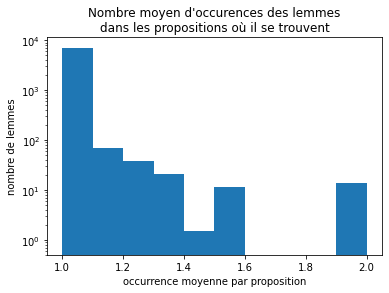

In [19]:
plt.hist(df["Nombre moyen par document"], log = True, bottom = .5)
plt.xlabel("occurrence moyenne par proposition")
plt.ylabel("nombre de lemmes")
_ = plt.title("Nombre moyen d'occurences des lemmes\ndans les propositions où il se trouvent")

In [20]:
df.sort_values(by = ['Nombre moyen par document'], inplace = True, ascending=False)
px.bar(df.iloc[:10,:], x = 'Lemme', y = 'Nombre moyen par document', title = "Nombre moyen d'occurences des lemmes dans les documents où il se trouvent")

In [32]:
with open('../data/docs.json', encoding = "utf8") as f:
    docs = json.load(f)

In [136]:
list_lemme = [lemme for prop in docs for lemme in prop]
value,count = np.unique(list_lemme,return_counts=True)
new_value = [x for _,x in sorted(zip(count,value))][::-1][:10]
new_count = [x for _,x in sorted(zip(count,count))][::-1]

fig = go.Figure([go.Bar(x=new_value,y=new_count)])
fig.update_layout(xaxis={"title":"Lemme","tickangle":0},
yaxis={"title":"Fréquence d'apparition"},title="Présence des lemmes dans le corpus",font_size=27,width=1250,height=700,)
fig.show()

In [138]:
list_lemme = [lemme for prop in docs for lemme in prop]
value,count = np.unique(list_lemme,return_counts=True)
max_value = 20
count[np.where(count >= max_value)] = max_value

print(len(count))

new_value = list(range(min(count),max_value+1))
new_count = []
for val in new_value:
    new_count.append(np.round(len(np.where(count == val)[0])/len(value)*100,2))
new_value = [str(val) for val in new_value]
new_value[len(new_value)-1] = f">={max_value}"

7231


In [139]:
fig = go.Figure([go.Bar(x=new_value,y=new_count)])
fig.update_layout(xaxis={"title":"Nombre d'apparitions dans le corpus","tickvals":[i for i in new_value],"tickangle":0},
yaxis={"title":"Proportion des lemmes(%)","ticksuffix":"%"},title="Présence des lemmes dans le corpus",font_size=27,width=1200,height=700)
fig.show()

In [2]:
with open('../data/req_makeorg_environnement.json', encoding = "utf8") as f:
    req = json.load(f)

In [144]:
value

array([list([]), list(['Alimentation']),
       list(['Bien être animal', 'Etat ', 'sanction', 'biodiversité', 'changement de politiques publiques', 'générale']),
       ...,
       list(['établissements scolaires', 'réparation', 'régulation', 'réduction des déchets', 'Milieu scolaire', 'générale']),
       list(['établissements scolaires', 'réparation', 'simplification administrative', 'Milieu scolaire', 'actionnable']),
       list(['établissements scolaires', 'énergies renouvelable', 'réparation', 'pollution (air, sol et eau)', 'Énergies et ressources', 'générale'])],
      dtype=object)

In [146]:
list_tag = [tag['label'] for prop in req['results'] for tag in prop['tags']]
value,count = np.unique(list_tag,return_counts=True)
new_value = [x for _,x in sorted(zip(count,value))][::-1][:10]
new_count = [x for _,x in sorted(zip(count,count))][::-1]

fig = go.Figure([go.Bar(x=new_value,y=new_count)])
fig.update_layout(xaxis={"title":"Lemme","tickangle":45},
yaxis={"title":"Fréquence d'apparition"},title="Présence des lemmes dans le corpus",font_size=27,width=1250,height=700,)
fig.show()

In [142]:
list_tag = [[tag['label'] for tag in prop['tags']] for prop in req['results']]

nb_tag = [len(tag) for tag in list_tag]
value,count = np.unique(nb_tag,return_counts=True)
px.histogram(nb_tag,labels={'value':'Nombre de Tags', 'y':'count'},histnorm='percent')

fig = go.Figure([go.Histogram(x=nb_tag,histnorm='percent')])
fig.update_layout(xaxis={"title":"Nombre de Tags","tickvals":list(range(min(nb_tag),max(nb_tag)+1))},
yaxis={"title":"Proportion des propositions(%)","ticksuffix":"%"},title="Distribution du nombre de tags par proposition",font_size=27,width=1200,height=700)
fig.show()

30% des propositions ne sont pas taguée

In [41]:
tags, freq_tag = np.unique([tag for _ in list_tag for tag in _],return_counts=True)
freq_tag
#
# value,count = np.unique(nb_tag,return_counts=True)
# px.histogram( freq_tag,labels={'value':'Nombre de Tags', 'y':'count'},histnorm='percent')

array([ 358,  231,  148,  621,  520,  120,  144,   97, 1808,   88,  145,
         66,  142,  822,   90,   19,  144,  235, 1027,  113,  181,   50,
        273, 1906,   23, 1643,   30,  301,  558,  596,   54, 1262,  506,
        614,   57,  771,  129,   30,   29,  458,  746,  611, 4717,  956,
        208,   30,   41,   42,   25,   27, 2156,  364,   38,  587, 1501,
       1008,   83, 5351,  560,  294,  545,    8,  588,   17,  647,  163,
        136])